In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, Flatten, SimpleRNN
from sklearn.model_selection import train_test_split
import os

In [2]:
# make dummy column on my way
def make_dummy_category(data):
    for i in range(27):
        data[f"category_{i+1}"] = [1 if category == (i+1) else 0 for category in data['category_id']]
    return data

In [3]:
def categorize_duration(duration):
    if duration <= 60:
        return 0
    elif duration <= 240:
        return 1
    elif duration <= 1200:
        return 2
    else:
        return 3

In [11]:
# Convert the data to a 2D array for training the LSTM model
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(1,len(data)):
        end_ix = i + n_steps
        if end_ix >= len(data):
            break
        # extract the input and output sequences
        seq_X, seq_y = data.iloc[i:end_ix, :-1].values, data.loc[end_ix, ['views_diff_scaled']]
        X.append(seq_X)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
#학습데이터 구성을 위한 파일 이름 섞기

#shuffle for data split, 
directory = 'DATA/video_preprocessed'
filenames= os.listdir(directory)

In [13]:
#학습데이터 구성

# set the directory path containing the CSV files
directory = 'DATA/video_preprocessed'
filenames= os.listdir(directory)
# columns = ['category_id', 'duration', 'update_diff', 'views_scaled', 'likes_scaled','time_gap_minutes']
# columns = ['category_id', 'duration', 'update_diff', 'views_scaled', 'likes_scaled','time_gap_minutes']
columns = ['category_id', 'duration', 'views_diff_scaled', 'likes_diff_scaled','hour']

# set the desired n_steps and threshold values
n_steps = 3
threshold = 43200
initX, inity = np.zeros((1,3,6)), np.zeros((1,2))
X = np.zeros((1,3,6))
Y = np.zeros((1,2))

# iterate over the files in the directory
for filename in filenames:
    # load the CSV file
    filepath = os.path.join(directory, filename)
    data = pd.read_csv(filepath)
    data = data[columns]

    #simple pre-processing to make one hot vector for category.
    data = make_dummy_category(data)
    data.drop(['category_id'],axis=1,inplace=True)
    data['duration'] = data['duration'].apply(categorize_duration)

        
    # prepare the data using the prepare_data() function
    tmpX, tmpy = prepare_data(data, n_steps=n_steps)
    # print(f"{filename}, x: {X.shape}, tmpx: {tmpX.shape}")
    if not np.array_equal(X,initX):
        if (tmpX.shape[1:3] == X.shape[1:3]):
            X = np.concatenate((X,tmpX),axis=0)
            Y = np.concatenate((Y,tmpy),axis=0)
    else:
        X = tmpX
        Y = tmpy
    

In [17]:
X_train.shape

(4999, 3, 30)

In [20]:
#make tensorflow model

def make_CNN_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1))

    return model

def make_RNN_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=input_shape))
    model.add(Dense(1,activation='sigmoid'))  # Output layer with single neuron for regression

    return model

In [23]:
X_train[0]

array([[ 3.        , -0.47144024, -1.06276151,  6.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 3.        , -0.36945703, -1.10041841,  7.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 3.        , -0.36462898, -0.9958159 ,  8.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

In [21]:
# Split the data into training and testing sets
# y = np.reshape(y, (32, ))  # reshape y to [32, 1]
split_idx = int(len(X) * 0.8) # 80% of the data will be used for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=321)


# Define the model
model = make_RNN_model((X_train.shape[1],X_train.shape[2]))
model = make_CNN_model((X_train.shape[1],X_train.shape[2]))

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Compile the model
mySGD = tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.1,weight_decay=0.0001,nesterov=True)
myRMS = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-06)
model.compile(optimizer=myRMS, loss='mse')

# Train the LSTM model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 2/100
125/125 [==============================] - 0s 936us/step - loss: nan - val_loss: nan
Epoch 3/100
125/125 [==============================] - 0s 992us/step - loss: nan - val_loss: nan
Epoch 4/100
125/125 [==============================] - 0s 887us/step - loss: nan - val_loss: nan
Epoch 5/100
125/125 [==============================] - 0s 871us/step - loss: nan - val_loss: nan
Epoch 6/100
125/125 [==============================] - 0s 912us/step - loss: nan - val_loss: nan
Epoch 7/100
125/125 [==============================] - 0s 871us/step - loss: nan - val_loss: nan
Epoch 8/100
125/125 [==============================] - 0s 871us/step - loss: nan - val_loss: nan
Epoch 9/100
125/125 [==============================] - 0s 871us/step - loss: nan - val_loss: nan
Epoch 10/100
125/125 [==============================] - 0s 871us/step - loss: nan - val_loss: nan
Epoch 11/100
125/125 [=========

In [ ]:
print(f"X shape = {X.shape}, y shape = {y.shape}")

In [ ]:
from keras.models import load_model
model.save('test_model.h5')

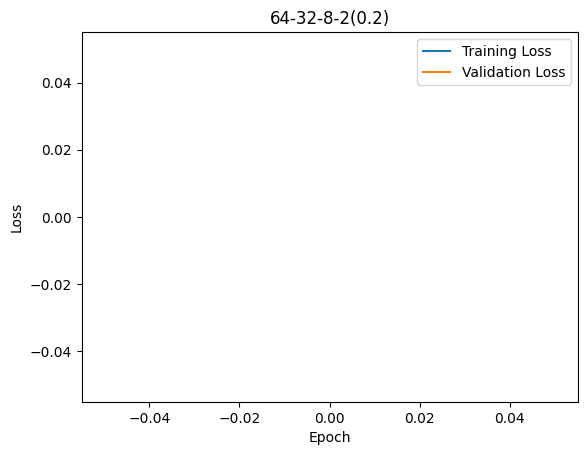

In [18]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('64-32-8-2(0.2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(3, 30)
1/1 [==============================] - 0s 13ms/step
(3, 30)
1/1 [==============================] - 0s 14ms/step
(3, 30)
1/1 [==============================] - 0s 15ms/step
(3, 30)
1/1 [==============================] - 0s 16ms/step
(3, 30)
1/1 [==============================] - 0s 15ms/step
(3, 30)
1/1 [==============================] - 0s 15ms/step
(3, 30)
1/1 [==============================] - 0s 15ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step
(3, 30)
1/1 [==============================] - 0s 15ms/step
(3, 30)
1/1 [==============================] - 0s 15ms/step
(3, 30)
1/1 [==============================] - 0s 17ms/step


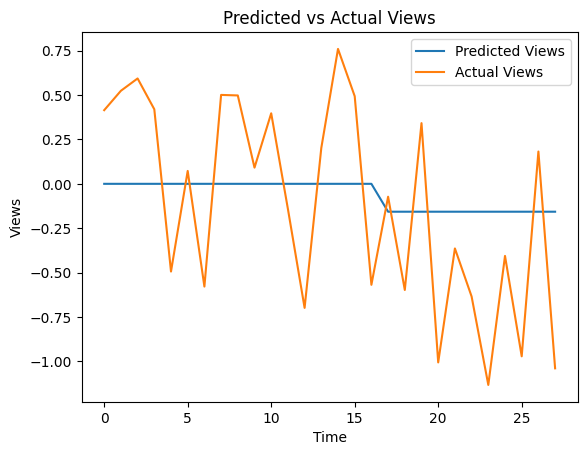

In [78]:
import matplotlib.pyplot as plt

# Assuming you have your predicted values in a variable called 'predicted_views'
# and actual values in a variable called 'actual_views'


# data = pd.read_csv('fortestpredict.csv')

data = pd.read_csv(r'DATA\videos_preprocessed\진격캐넌_단퐁회_20230509.csv')
columns = ['category_id', 'duration', 'views_scaled', 'likes_scaled', 'time_gap_minutes']
data = data[columns]
data = make_dummy_category(data)
data.drop(['category_id'],axis=1,inplace=True)
data['duration'] = data['duration'].apply(categorize_duration)
x, y = prepare_data(data,3,43200)
actual_views = np.array(data['views_scaled'])
predicted_views = [0] * (len(actual_views)-len(x))

for tmpx in x:
    print(tmpx.shape)
    predicted_views.append(model.predict(tmpx.reshape(1,3,30))[0][0])

# Get the time index for plotting
time_index = range(len(predicted_views))

# Plot the predicted views and actual views
plt.plot(time_index, predicted_views, label='Predicted Views')
plt.plot(time_index, actual_views, label='Actual Views')

# Set labels and title for the graph
plt.xlabel('Time')
plt.ylabel('Views')
plt.title('Predicted vs Actual Views')

# Add a legend
plt.legend()

# Display the graph
plt.show()


In [62]:
predicted_views = [0,0,0]

for tmpx in x:
    result = model.predict(tmpx.reshape(1,3,30))
    print(result)
    predicted_views.append(result[0][0])

predicted_views

1/1 [==============================] - 0s 13ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 16ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 15ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 14ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 16ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 17ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 14ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 14ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 15ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 14ms/step
[[-0.18533799]]
1/1 [==============================] - 0s 14ms/step
[[-0.18533799]]


[0,
 0,
 0,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799,
 -0.18533799]